# 10-703: Behavior Cloning, DAGGER, and GAIL

You will implement this assignment right here in this Colab notebook. Colab is a Jupyter notebook that runs in the cloud. If you haven't used Colab before, we recommend checking out the following tutorial:
https://colab.sandbox.google.com/notebooks/welcome.ipynb.
Note that all cells modify the same global state, so imported packages as well as functions and variables declared in one cell will be accessible in other cells.


To get started, click the ``Open in Playground`` button in the upper right. Then click the ``Copy to Drive`` button in the upper center to save a copy in your Google drive. In the future, you will be able to find the notebook by looking in your Google drive folder.

Now, you're ready start coding. 



### Setup: Import Dependencies

In [ ]:
from collections import OrderedDict 
import gym
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import random
import tensorflow as tf

Using TensorFlow backend.


### Make the TF Model


In [ ]:
def make_model():
  model = Sequential()      
  # WRITE CODE HERE
  model.add(Dense(10, activation=tf.nn.tanh, input_dim=4))
  model.add(Dense(2, activation=tf.nn.softmax))
  # Add layers to the model:
  # a fully connected layer with 10 units
  # a tanh activation
  # another fully connected layer with 2 units (the number of actions)
  # a softmax activation (so the output is a proper distribution)
  model.compile(loss='categorical_crossentropy',
                     optimizer=tf.train.AdamOptimizer(),
                     metrics=['accuracy'])
  
  # We expect the model to have four weight variables (a kernel and bias for
  # both layers)
  assert len(model.weights) == 4, 'Model should have 4 weights.'
  return model

### Test the model
To confirm that the model is correct, we'll use it to solve a binary classification problem. The target function $f: \mathbb{R}^4 \rightarrow {0, 1}$ indicates whether the sum of the vector coordinates is positive:
$$f(x) = \delta \left(\sum_{i=1}^4 x_i > 0 \right)$$

You should achieve an accuracy of at least 98%.

In [ ]:
model = make_model()
for t in range(20):
  X = np.random.normal(size=(1000, 4))  # some random data
  is_positive = np.sum(X, axis=1) > 0  # A simple binary function
  Y = np.zeros((1000, 2))
  Y[np.arange(1000), is_positive.astype(int)] = 1  # one-hot labels
  history = model.fit(X, Y, epochs=10, batch_size=256, verbose=0)
  loss = history.history['loss'][-1]
  acc = history.history['acc'][-1]
  print('(%d) loss= %.3f; accuracy = %.1f%%' % (t, loss, 100 * acc))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







(0) loss= 0.487; accuracy = 80.3%
(1) loss= 0.408; accuracy = 88.0%
(2) loss= 0.325; accuracy = 93.2%
(3) loss= 0.284; accuracy = 94.9%
(4) loss= 0.252; accuracy = 96.3%
(5) loss= 0.218; accuracy = 97.6%
(6) loss= 0.192; accuracy = 96.8%
(7) loss= 0.180; accuracy = 97.4%
(8) loss= 0.148; accuracy = 98.3%
(9) loss= 0.140; accuracy = 98.2%
(10) loss= 0.127; accuracy = 99.1%
(11) loss= 0.125; accuracy = 98.7%
(12) loss= 0.126; accuracy = 98.5%
(13) loss= 0.107; accuracy = 98.7%
(14) loss= 0.096; accuracy = 99.1%
(15) loss= 0.088; accuracy = 99.1%
(16) loss= 0.088; accuracy = 99.1%
(17) loss= 0.081; accuracy = 99.6%
(18) loss= 0.079; accuracy = 99.4%
(19) loss= 0.079; accuracy = 99.3%


### Interacting with the Gym
Implement the function below for gathering an episode (a "rollout"). The environment we will use will implement the OpenAI Gym interface. For documentation, please see the link below:
http://gym.openai.com/docs/#environments

In [ ]:
def action_to_one_hot(env, action):
    action_vec = np.zeros(env.action_space.n)
    action_vec[action] = 1
    return action_vec    
      
      
def generate_episode(env, policy):
  """Collects one rollout from the policy in an environment. The environment
  should implement the OpenAI Gym interface. A rollout ends when done=True. The
  number of states and actions should be the same, so you should not include
  the final state when done=True.

  Args:
    env: an OpenAI Gym environment.
    policy: a keras model
  Returns:
    states: a list of states visited by the agent.
    actions: a list of actions taken by the agent. While the original actions
      are discrete, it will be helpful to use a one-hot encoding. The actions
      that you return should be one-hot vectors (use action_to_one_hot())
    rewards: the reward received by the agent at each step.
  """
  done = False
  state = env.reset()

  states = []
  actions = []
  rewards = []
  while not done:
      states.append(state)
      action = policy.predict_classes(np.array([state]))[0]
      state, reward, done, info = env.step(action)
      action = action_to_one_hot(env, action)
      actions.append(action)
      rewards.append(reward)
  return np.array(states), np.array(actions), np.array(rewards)

### Test the data collection
Run the following cell and make sure you see "Test passed!"

In [ ]:
# Create the environment.
env = gym.make('CartPole-v0')
policy = make_model()
states, actions, rewards = generate_episode(env, policy)
assert len(states) == len(actions), 'Number of states and actions should be equal.'
assert len(actions) == len(rewards), 'Number of actions and rewards should be equal.'
assert len(actions[0]) == 2, 'Actions should use one-hot encoding.'
print('Test passed!')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test passed!


### Download the expert policy
Run the cell below to upload the expert policy (`expert.h5`) to the Colab runtime.

In [ ]:
!wget https://raw.githubusercontent.com/cmudeeprl/703website/master/assets/homework/hw1/expert.h5

--2020-03-06 19:24:34--  https://raw.githubusercontent.com/cmudeeprl/703website/master/assets/homework/hw1/expert.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44536 (43K) [application/octet-stream]
Saving to: ‘expert.h5’

expert.h5           100%[===================>]  43.49K  --.-KB/s    in 0.02s   

2020-03-06 19:24:34 (1.77 MB/s) - ‘expert.h5’ saved [44536/44536]



## Behavior Cloning and DAGGER

In [ ]:
class Imitation():

    def __init__(self, env, num_episodes):
        self.env = env
        self.expert = tf.keras.models.load_model('expert.h5')
        self.num_episodes = num_episodes
        
        
        self.model = make_model()
        
    def generate_behavior_cloning_data(self):
        self._train_states = []
        self._train_actions = []
        for _ in range(self.num_episodes):
            states, actions, rewards = generate_episode(self.env, self.expert)
            self._train_states.extend(states)
            self._train_actions.extend(actions)
        self._train_states = np.array(self._train_states)
        self._train_actions = np.array(self._train_actions)
        
    def generate_dagger_data(self):
        self._train_states = []
        self._train_actions = []
        for _ in range(self.num_episodes):
            states, _, rewards = generate_episode(self.env, self.model)
            self._train_states.extend(states)
            actions = self.expert.predict_classes(states)
            for i in range(len(actions)):
              self._train_actions.append(action_to_one_hot(self.env, actions[i]))
        self._train_states = np.array(self._train_states)
        self._train_actions = np.array(self._train_actions)
        
    def train(self, num_epochs=200):
        """Trains the model on training data generated by the expert policy.
        Args:
          env: The environment to run the expert policy on.
          num_epochs: number of epochs to train on the data generated by the expert.
        Return:
          loss: (float) final loss of the trained policy.
          acc: (float) final accuracy of the trained policy
        """

        history = self.model.fit(x=self._train_states, y=self._train_actions,
                            epochs=num_epochs, verbose=0, shuffle=True)
        loss = history.history['loss'][-1]
        acc = history.history['acc'][-1]

        return loss, acc


    def evaluate(self, policy, n_episodes=50):
        rewards = []
        for i in range(n_episodes):
            _, _, r = generate_episode(self.env, policy)
            rewards.append(sum(r))
        r_mean = np.mean(rewards)
        return r_mean

### Experiment: Student vs Expert


In [ ]:
# Uncomment one of the two lines below to select whether to run behavior
# cloning or dagger
#mode = 'behavior cloning'
mode = 'dagger'

num_episodes = [100, 50, 10, 1]  
num_iterations = 100  # Number of training iterations. Use a small number
                     # (e.g., 10) for debugging, and then try a larger number
                     # (e.g., 100).

loss_vec = [[],[],[],[]]
acc_vec = [[],[],[],[]]
imitation_reward_vec = [[],[],[],[]]
for i in range(4):
# Create the environment.
  env = gym.make('CartPole-v0')
  im = Imitation(env, num_episodes[i])
  expert_reward = im.evaluate(im.expert)
  print('Expert reward: %.2f' % expert_reward)

  for t in range(num_iterations):
    if mode == 'behavior cloning':
      im.generate_behavior_cloning_data()
    elif mode == 'dagger':
      im.generate_dagger_data()
    else:
      raise ValueError('Unknown mode: %s' % mode)
    loss, acc = im.train(num_epochs=1)
    imitation_reward = im.evaluate(im.model)
    loss_vec[i].append(loss)
    acc_vec[i].append(acc)
    imitation_reward_vec[i].append(imitation_reward)
    print('(%d) loss = %.3f; accuracy = %.2f; reward = %.1f' % (t, loss, acc, imitation_reward))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Expert reward: 200.00
(0) loss = 0.731; accuracy = 0.33; reward = 21.6
(1) loss = 0.597; accuracy = 0.75; reward = 20.4
(2) loss = 0.494; accuracy = 0.90; reward = 48.2
(3) loss = 0.531; accuracy = 0.79; reward = 45.8
(4) loss = 0.416; accuracy = 0.87; reward = 55.1
(5) loss = 0.362; accuracy = 0.88; reward = 80.4
(6) loss = 0.250; accuracy = 0.92; reward = 200.0
(7) loss = 0.349; accuracy = 0.90; reward = 173.4
(8) loss = 0.184; accuracy = 0.94; reward = 200.0
(9) loss = 0.197; accuracy = 0.96; reward = 196.7
(10) loss = 0.211; accuracy = 0.91; reward = 200.0
(11) loss = 0.199; accuracy = 0.91; reward = 199.9
(12) loss = 0.198; accuracy = 0.92; reward = 200.0
(13) loss = 0.075; accuracy = 0.97; reward = 200.0
(14) loss = 0.106; accuracy = 0.96; reward = 192.3
(15) loss = 0.096; accuracy = 0.96; reward = 200.0
(16) loss = 0.093; accuracy = 0.96; reward = 194.9
(17) loss = 0.074; accuracy = 0.97; reward = 200.0
(18) loss = 0.109; accuracy = 0.96; reward = 199.0
(19) loss = 0.077; accura

### Plot the results
After saving your plots by running `plt.savefig(FILENAME)`, you can download them by navigating to the `Files` tab on the left, and then right-clicking on each filename and selecting `Download`.

In [ ]:
### Plot the results
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.title('Reward')
for i in range(4):
  plt.plot(imitation_reward_vec[i], label='%d episodes/iteration' % (num_episodes[i]))
plt.hlines(expert_reward, 0, len(imitation_reward_vec), label='expert')
plt.legend(loc=(1, 0.5), handlelength=1, prop={'size': 8})
plt.xlabel('iterations')
plt.ylabel('Returns')
plt.ylim([0, None])

plt.subplot(132)
plt.title('Loss')
for i in range(4):
  plt.plot(loss_vec[i], label ="%d episodes per iteration"  % (num_episodes[i]))
plt.legend(("100 episodes", '50 episodes', '10 episodes', '1 episode'), loc=(1, 0.5), handlelength=1, prop={'size': 8})
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(133)
plt.title('Accuracy')
for i in range(4):
  plt.plot(acc_vec[i], label="%d episodes per iteration" % (num_episodes[i]))
plt.legend(("100 episodes", '50 episodes', '10 episodes', '1 episode'),loc=(1, 0.5), handlelength=1, prop={'size': 8})
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('student_vs_expert_%s.png' % mode, dpi=300)
plt.show()

### Experiment: How much expert data is needed?
This question studies how the amount of expert data effects the performance. You will run the same experiment as above, each time varying the number of expert episodes collected at each iteration. Use values of 1, 10, 50, and 100. You can keep the number of iterations fixed at 100.

In [ ]:

# cloning or dagger
mode = 'behavior cloning'
# mode = 'dagger'

random_seeds = 5
# Dictionary mapping number of expert trajectories to a list of rewards.
# Each is the result of running with a different random seed.
reward_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
accuracy_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
loss_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})

for num_episodes in [1, 10, 50, 100]:
  for t in range(random_seeds):
    print('num_episodes: %s; seed: %d' % (num_episodes, t))
    random.seed(t)
    env = gym.make('CartPole-v0')
    im = Imitation(env, num_episodes)
    expert_reward = im.evaluate(im.expert)
    print('Expert reward: %.2f' % expert_reward)
    for t in range(1):
      if mode == 'behavior cloning':
        im.generate_behavior_cloning_data()
      elif mode == 'dagger':
        im.generate_dagger_data()
      else:
        raise ValueError('Unknown mode: %s' % mode)
      loss, acc = im.train(num_epochs=1)
      imitation_reward = im.evaluate(im.model)
      loss_data[num_episodes].append(loss)
      accuracy_data[num_episodes].append(acc)
      reward_data[num_episodes].append(imitation_reward)
      print('(%d) loss = %.3f; accuracy = %.2f; reward = %.1f' % (t, loss, acc, imitation_reward))


num_episodes: 1; seed: 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Expert reward: 200.00


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-cff59c794ae9>", line 42, in <module>
    imitation_reward = im.evaluate(im.model)
  File "<ipython-input-7-62c815834748>", line 59, in evaluate
    _, _, r = generate_episode(self.env, policy)
  File "<ipython-input-4-6fd70aae1e17>", line 32, in generate_episode
    action = policy.predict_classes(np.array([state]))[0]
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py", line 268, in predict_classes
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1401, in predict
    callbacks=callbacks)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 332, in predict_loop
    batch_outs = f(ins_batch)
  File "/usr/local/lib/python

KeyboardInterrupt: ignored

In [ ]:
mode = 'behavior cloning'

random_seeds = 5
# Dictionary mapping number of expert trajectories to a list of rewards.
# Each is the result of running with a different random seed.
reward_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
accuracy_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
loss_data = OrderedDict({  
    1: [],
    10: [],
    50: [],
    100: []
})
for num_episodes in [1, 10, 50, 100]:
  for t in range(random_seeds):
    print('num_episodes: %s; seed: %d' % (num_episodes, t))
    random.seed(t)

    num_iterations = 100
    # Create the environment.
    env = gym.make('CartPole-v0')
    im = Imitation(env, num_episodes)
    expert_reward = im.evaluate(im.expert)
    print('Expert reward: %.2f' % expert_reward)

    loss_vec = []
    acc_vec = []
    imitation_reward_vec = []
    for iteration in range(num_iterations):
      if mode == 'behavior cloning':
        im.generate_behavior_cloning_data()
      elif mode == 'dagger':
        im.generate_dagger_data()
      else:
        raise ValueError('Unknown mode: %s' % mode)
      loss, acc = im.train(num_epochs=1)
      imitation_reward = im.evaluate(im.model)
      loss_vec.append(loss)
      acc_vec.append(acc)
      imitation_reward_vec.append(imitation_reward)
      print('(%d) loss = %.3f; accuracy = %.2f; reward = %.1f' % (iteration, loss, acc, imitation_reward))

    reward_data[num_episodes].append(imitation_reward_vec)
    accuracy_data[num_episodes].append(acc_vec)
    loss_data[num_episodes].append(loss_vec)

plt.figure(figsize=(12, 12))
for i in range(4):
  key = keys[i]
  data = [reward_data, accuracy_data, loss_data]
  names = ['reward', 'accuracy', 'loss']
  for j in range(3):
    for k in range(random_seeds):
      plt.subplot(4, 3, (i * 3) + j + 1)
      plt.plot(list(range(50)), data[j][key][k])
      plt.xlabel('number of expert trajectories', fontsize=8)
      if j == 0:
        plt.ylabel("Number of Episodes: " + str(key) + "\n" + str(names[j]), fontsize=8)
      else:
        plt.ylabel(names[j], fontsize=8)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.legend(["Random Seed: " + str(x) for x in range(random_seeds)])
plt.savefig('expert_data_%s.png' % mode, dpi=300)
plt.show()

num_episodes: 1; seed: 0


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Expert reward: 200.00
(0) loss = 0.739; accuracy = 0.37; reward = 9.0
(1) loss = 0.728; accuracy = 0.30; reward = 9.1
(2) loss = 0.721; accuracy = 0.21; reward = 9.2
(3) loss = 0.715; accuracy = 0.35; reward = 9.3
(4) loss = 0.709; accuracy = 0.40; reward = 9.0
(5) loss = 0.705; accuracy = 0.43; reward = 9.2
(6) loss = 0.697; accuracy = 0.47; reward = 9.1
(7) loss = 0.691; accuracy = 0.51; reward = 10.8
(8) loss = 0.685; accuracy = 0.68; reward = 15.9
(9) loss = 0.680; accuracy = 0.56; reward = 24.5
(10) loss = 0.674; accuracy = 0.63; reward = 28.9
(11) loss = 0.669; accuracy = 0.74; reward = 28.1
(12) loss = 0.663; accuracy = 0.73; reward = 30.0
(13) loss = 0.658; accuracy = 0.82; reward = 30.9
(14) loss = 0.655; accuracy = 0.70; reward = 35.9
(15) loss = 0.647; accuracy = 0.81; reward = 34.9
(16) loss = 0.642; accuracy = 0.83; reward = 34.0
(17) loss = 0.637; accuracy = 0.80; reward = 33.9
(18) loss = 0.632; accuracy = 0.80; reward = 37.5
(19) loss = 0.627; accuracy = 0.73; reward = 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curre

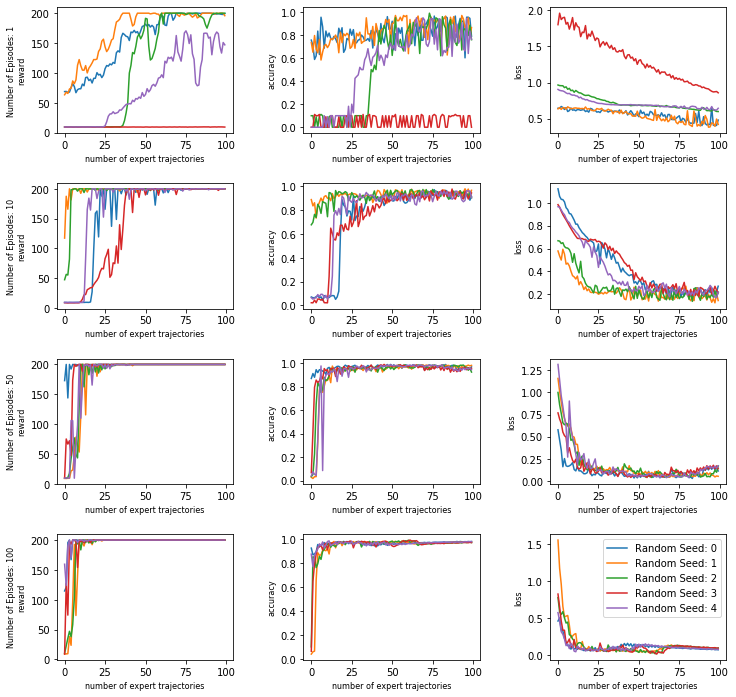

In [ ]:
keys = [1, 10, 50, 100]
plt.figure(figsize=(12, 12))
for i in range(4):
  key = keys[i]
  data = [reward_data, accuracy_data, loss_data]
  names = ['reward', 'accuracy', 'loss']
  for j in range(3):
    for k in range(random_seeds):
      plt.subplot(4, 3, (i * 3) + j + 1)
      plt.plot(list(range(100)), data[j][key][k])
      plt.xlabel('number of expert trajectories', fontsize=8)
      if j == 0:
        plt.ylabel("Number of Episodes: " + str(key) + "\n" + str(names[j]), fontsize=8)
      else:
        plt.ylabel(names[j], fontsize=8)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.legend(["Random Seed: " + str(x) for x in range(random_seeds)])
plt.savefig('expert_data_%s.png' % mode, dpi=300)
plt.show()